In [1]:
!pip freeze > requirements.txt

In [7]:
%matplotlib notebook
#%matplotlib widget

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import py_vollib_vectorized

### Release 

In [4]:
def generate_random_walk(n=100, shift = 50):
    """Generate a simple random walk with n steps."""
    x = list(np.arange(n))
    y = list(np.cumsum(np.random.randn(n)) + shift)
    return x, y

def create_structure(positions, types, strikes):
    ret_lst = [(positions[i], types[i], strikes[i]) for i in range(len(positions))]
    return ret_lst


def get_structure_price(structure, underlying_price, iv, r, T):
    """
    Calculate the price of a multi-leg option structure, returning the total price, intrinsic,
    and extrinsic components.

    Parameters
    ----------
    structure : list of tuples
        Each tuple is (position, contract_type, strike), where contract_type is "call" or "put".
    underlying_price : float
        The current price of the underlying.
    iv : float
        The implied volatility (e.g. 0.35).
    r : float
        The risk-free interest rate (e.g. 0.05).
    T : float
        Time to expiration in years (e.g. dte / 365).
    
    Returns
    -------
    total_option_price : float
        Sum of (position * option price) for all legs.
    total_intrinsic : float
        Sum of (position * intrinsic value) for all legs.
    total_extrinsic : float
        Total option price minus total intrinsic.
    """
    total_option_price = 0.0
    total_intrinsic = 0.0

    for pos, contract_type, strike in structure:
        # Compute intrinsic value
        if contract_type.lower() in ['call', 'c']:
            intrinsic = max(0, underlying_price - strike)
            flag = 'c'
        else:
            intrinsic = max(0, strike - underlying_price)
            flag = 'p'
        
        # Compute option price using Black-Scholes formula (assume q=0)
        option_price = py_vollib_vectorized.models.vectorized_black_scholes(flag, underlying_price, strike, T, r, iv).iloc[0, 0]
        
        total_option_price += pos * option_price
        total_intrinsic += pos * intrinsic

    total_extrinsic = total_option_price - total_intrinsic
    return total_option_price, total_intrinsic, total_extrinsic

<IPython.core.display.Javascript object>


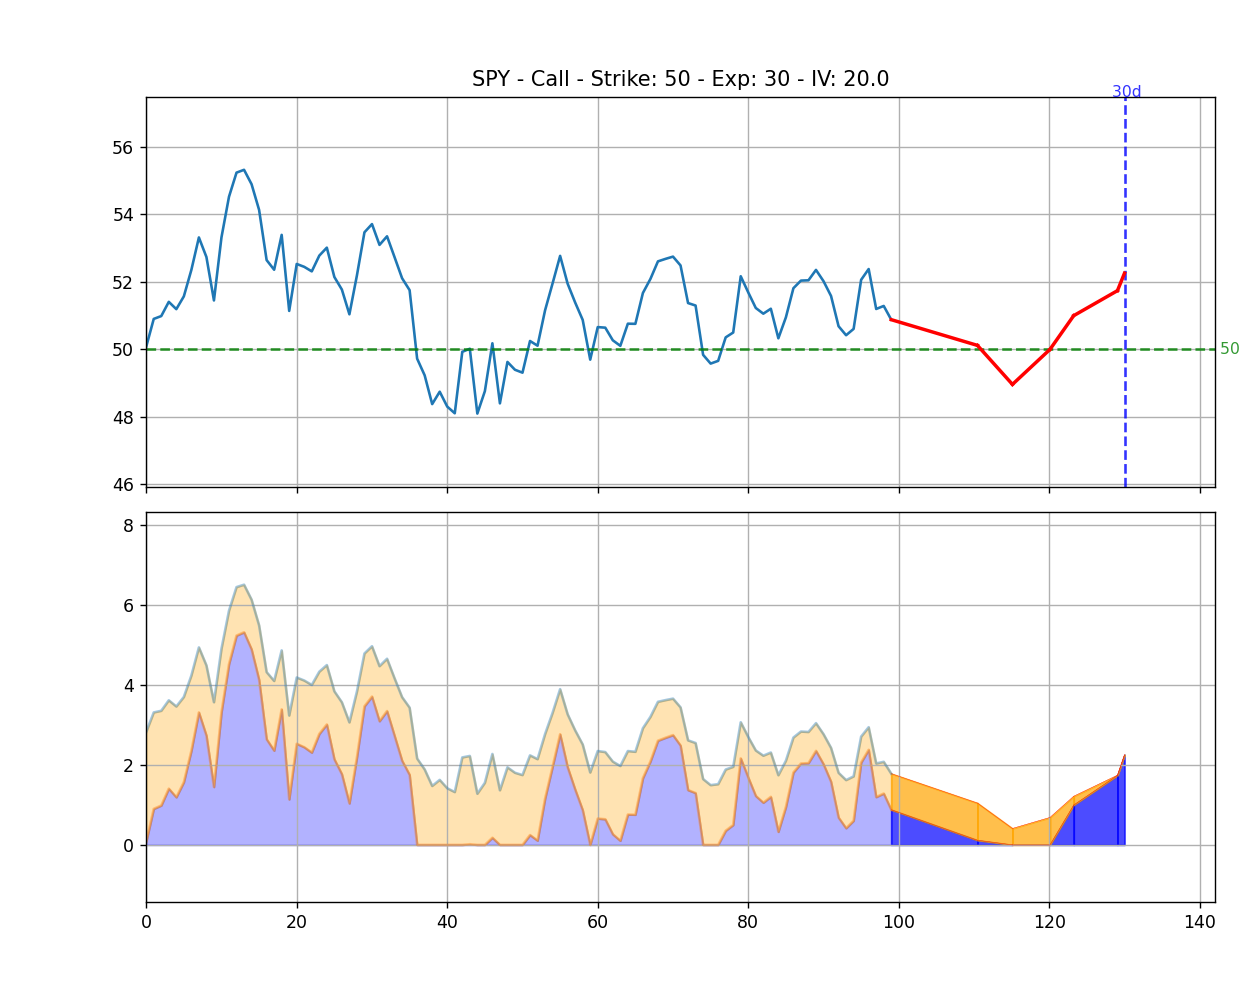

Output()

In [6]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Define control options
underlying_options = ['SPY', 'AAPL', 'TSLA', 'GOOGL']
option_types = ['Call', 'Put']
strike_options = [40, 50, 60]
expiration_options = [30, 60, 90]
init_position_val = 1

add_space_mult = 1.6
expiration_space_mult = 1.4

# Create dropdown widgets, a submit button, and an IV slider
underlying_input = widgets.Text(value='SPY', description='Underlying:')
position_input = widgets.IntText(value = init_position_val, description='Position:')
option_type_dropdown = widgets.Dropdown(options=option_types, description='Option:')
strike_dropdown = widgets.Dropdown(options=strike_options, description='Strike:')
expiration_dropdown = widgets.Dropdown(options=expiration_options, description='Exp:')
submit_button = widgets.Button(description='Reload')
iv_slider = widgets.FloatSlider(value=20.0, min=0.0, max=100.0, step=0.1, description='IV:')

# Create an output widget for printing click coordinates
output = widgets.Output()

# Create figure and axis for the random walk plot.
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=False)
ax = axs[0]
ax.set_xlim(0, 200)
ax.set_ylim(-50, 50)
ax.grid()
ax.set_title("Random Walk - Click to extend")
(line,) = ax.plot([], [], linestyle='-', label='Random Walk')


ax_opt = axs[1]
ax_opt.grid()
(opt_line,) = ax_opt.plot([], [], linestyle='-', label='Option Structure', alpha = 0.4)
(int_line,) = ax_opt.plot([], [], linestyle='-', label='Intrinsic Structure', alpha = 0.4)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Global variable to store the "last point" for drawing lines
trajectory = None
intrinsic_trajectory = None
total_opt_trajectory = None
straight_lines = []
texts = []
strikes = []
exp = None
len_start_candles = 100
structure = []
fills = []



def update_plot(*args):
    """Callback for the Submit button: regenerate the random walk and remove red lines."""
    global trajectory, straight_lines, texts, strikes, exp, len_start_candles, structure
    global intrinsic_trajectory, total_opt_trajectory, fills
    # Remove red lines (extensions) from the axis.
    for artist in ax.lines[:]:
        if artist.get_color() == 'red':
            artist.remove()
    
    for artist in ax_opt.lines[:]:
        if artist.get_color() == 'red':
            artist.remove()  
    
    # Remove the strike lines
    for ln in straight_lines:
        ln.remove()
    straight_lines.clear()
    
    for f in fills[:]:
        f.remove()
    fills.clear()
    
    for t in texts:
        t.remove()
    texts.clear()

    structure = create_structure(
        [position_input.value], 
        [option_type_dropdown.value[0].lower()], 
        [strike_dropdown.value]
    )
    
    # Generate a new random walk.
    x, y = generate_random_walk(len_start_candles)#, shift = 50)
    total_opt_df = pd.DataFrame([get_structure_price(
        structure, # Global variable
        y[i], # This is effectively the price we clicked
        iv = iv_slider.value / 100, 
        r = 0.045, 
        T = (expiration_dropdown.value + len_start_candles - x[i]) / 365
    ) for i in range(len(y))
    ])
    total_prices = total_opt_df.iloc[:, 0].tolist()
    intrinsic_prices = total_opt_df.iloc[:, 1].tolist()

    
    line.set_data(x, y)
    opt_line.set_data(x, total_prices)
    int_line.set_data(x, intrinsic_prices)
    
    fill_intrinsic = ax_opt.fill_between(x, intrinsic_prices, 0, color='blue', alpha=0.3, label='Intrinsic')
    fills.append(fill_intrinsic)
    
    # Fill between total option price and intrinsic with another color (e.g., orange)
    fill_extrinsic = ax_opt.fill_between(x, total_prices, intrinsic_prices, color='orange', alpha=0.3, label='Extrinsic')
    fills.append(fill_extrinsic)
                              
    
    
    # Update plot title with the IV value.
    iv_value = iv_slider.value
    ax.set_title(f"{underlying_input.value} - {option_type_dropdown.value} - Strike: {strike_dropdown.value} - Exp: {expiration_dropdown.value} - IV: {iv_value}")
    

    strikes = [strike_dropdown.value]
    exp = expiration_dropdown.value
    y_min, y_max = get_y_lims(y, add_space_mult, strikes)
    ax.set_ylim(y_min, y_max)
    
    y_opt_min, y_opt_max = get_y_lims(total_prices, add_space_mult)
    ax_opt.set_ylim(y_opt_min, y_opt_max)
    
    if True: # Plotting strikes and expiration
        for strike in strikes:
            hl = ax.axhline(strike, color='green', linestyle='--', linewidth=1.5, alpha=0.8)
            straight_lines.append(hl)
            # Optionally, annotate the strike value on the right edge of the plot:
            txt = ax.text(ax.get_xlim()[1], strike, f" {strike}", 
                    color='green', va='center', fontsize=9, alpha=0.8)
            texts.append(txt)

        vl = ax.axvline(len(x) + exp, color='blue', linestyle='--', linewidth=1.5, alpha=0.8)
        straight_lines.append(vl)
        # Optionally, annotate the expiration (e.g., number of days) at the top:
        txt = ax.text(len(x) + exp, ax.get_ylim()[1], f" {exp}d", 
                color='blue', ha='center', fontsize=9, alpha=0.8)
        texts.append(txt)
        
        ax.set_xlim(0, len(x) + exp * expiration_space_mult)
    
    # Reset the last point to the end of the random walk.
    trajectory = [x, y]
    total_opt_trajectory = [x, total_prices]
    intrinsic_trajectory = [x, intrinsic_prices]
    fig.canvas.draw_idle()

def get_y_lims(y, add_mult, strikes = []):
    if len(strikes) == 0:
        max_str = y[0]
        min_str = y[0]
    else:
        max_str = np.max(strikes)
        min_str = np.min(strikes)
    mx = max(np.max(y), max_str)
    mn = min(np.min(y), min_str)
    y_amplitude = (mx - mn) / 2
    y_mid = (mx + mn) / 2
    y_min = y_mid - y_amplitude * add_mult
    y_max = y_mid + y_amplitude * add_mult
    
    return y_min, y_max
    
    
def onclick(event):
    """Callback for mouse clicks on the plot: draw a line from last_point to the clicked point and print coordinates."""
    global trajectory, strikes, exp, len_start_candles, structure
    global intrinsic_trajectory, total_opt_trajectory
    if event.inaxes != ax or trajectory is None:
        return
    x_click, y_click = event.xdata, event.ydata
    
    # We do not want to continue the price into the past
    if trajectory[0][-1] >= x_click:
        return
    
    # We do not want to plot anything if we are on expiration
    if trajectory[0][-1] == len_start_candles + exp:
        return
    
    # If we click to the right of the expiration then we have to constraint ourselves
    if x_click >= len_start_candles + exp:
        x_click = len_start_candles + exp
    # Draw a red line from the last point to the clicked location.
    ax.plot([trajectory[0][-1], x_click], [trajectory[1][-1], y_click],
            color='red', linewidth=2)
    # Update the last point.
    trajectory = [trajectory[0] + [x_click], trajectory[1] + [y_click]]
    
    # Resetting the y-axis for underlying
    #strikes = [strike_dropdown.value]
    y_min, y_max = get_y_lims(trajectory[1], add_space_mult, strikes)
    ax.set_ylim(y_min, y_max)
    
    
    # Now it is time to calculate the option prices
    dte = (expiration_dropdown.value + len_start_candles - x_click) / 365    
    total_option_price, total_intrinsic, total_extrinsic = get_structure_price(
        structure, # Global variable
        y_click, # This is effectively the price we clicked
        iv = iv_slider.value / 100, 
        r = 0.045, 
        T = dte
    )
    ax_opt.plot([total_opt_trajectory[0][-1], x_click], [total_opt_trajectory[1][-1], total_option_price],
            color='red', linewidth=0.2)
    ax_opt.plot([intrinsic_trajectory[0][-1], x_click], [intrinsic_trajectory[1][-1], total_intrinsic],
            color='red', linewidth=0.2)
    
    fill_intrinsic = ax_opt.fill_between([intrinsic_trajectory[0][-1], x_click],
                        [intrinsic_trajectory[1][-1], total_intrinsic],
                        [0, 0],
                        color='blue', alpha=0.7)
    fills.append(fill_intrinsic)
    fill_extrinsic = ax_opt.fill_between([total_opt_trajectory[0][-1], x_click],
                        [total_opt_trajectory[1][-1], total_option_price],
                        [intrinsic_trajectory[1][-1], total_intrinsic],
                        color='orange', alpha=0.7)
    fills.append(fill_extrinsic)
    
    total_opt_trajectory = [total_opt_trajectory[0] + [x_click], total_opt_trajectory[1] + [total_option_price]]
    intrinsic_trajectory = [intrinsic_trajectory[0] + [x_click], intrinsic_trajectory[1] + [total_intrinsic]]
    
    x = intrinsic_trajectory[0][len_start_candles:]
    intrinsic_prices = intrinsic_trajectory[1][len_start_candles:]
    total_prices = total_opt_trajectory[1][len_start_candles:]
    #fill_intrinsic = ax_opt.fill_between(x, intrinsic_prices, 0, color='blue', alpha=0.3, label='Intrinsic')
    #fill_extrinsic = ax_opt.fill_between(x, total_prices, intrinsic_prices, color='orange', alpha=0.3, label='Extrinsic')
    y_opt_min, y_opt_max = get_y_lims(total_opt_trajectory[1], add_space_mult)
    ax_opt.set_ylim(y_opt_min, y_opt_max)
    
    # Print the coordinates to the output widget.
    with output:
        print(f"Clicked at: x = {x_click:.2f}, y = {y_click:.2f}, opt = {total_option_price:.2f}")
    
    fig.canvas.draw_idle()

# Connect events.
cid = fig.canvas.mpl_connect('button_press_event', onclick)
submit_button.on_click(update_plot)

# Arrange and display the controls and output above the plot.
controls = widgets.VBox([underlying_input, position_input, option_type_dropdown, strike_dropdown, expiration_dropdown, iv_slider, submit_button])
display(controls)
display(output)

# Generate the initial random walk.
update_plot()
